# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Требования по качеству**: F-мера должна быть больше или равной 0,59.

# Содержание

1.   [Знакомство с данными](#1)
2.   [Подготовка данных](#2)
3.   [Исследование задачи](#3)
4.   [Борьба с дисбалансом](#4)
5.   [Тестирование модели](#5)
6.   [Общий вывод](#6)


# Знакомство с данными<a id="1"></a>

Прежде всего, подключим необходимые модули для работы с данными

In [1]:
%pip install pandas --upgrade

  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib --upgrade

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install seaborn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install sklearn --upgrade

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=c278b74aa25d8375971a93c93769ba3b74f2a36e81c847da7de6a4218f73632f
  Stored in directory: c:\users\sanek\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install numpy --upgrade

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.1 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.23.1 which is incompatible.


In [6]:
# убрать все предупреждения
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
# для работы с данными
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

d:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
# для работы с МашОбом
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve
from sklearn.utils import shuffle

In [9]:
# сами алгоритмы обучения (для задачи классификации)
# выбрал логистическую регрессию и случайный лес, потому что дают лучшие результаты
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [10]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

Посмотрим на общую информацию о таблице: данные в столбце, количество объектов, признаков.

In [11]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [13]:
data.shape

(10000, 14)

## Описание данных

**Признаки**

*   `RowNumber` - индекс строки в данных;
*   `CustomerId` - уникальный индентификатор клиента;
*   `Surname` - фамилия;
*   `CreditScore` - кредитный рейтинг;
*   `Geography` - страна проживания;
*   `Gender` - пол;
*   `Age` - возраст;
*   `Tenure` - сколько лет человек является клиентом банка;
*   `Balance` - баланс на счете;
*   `NumOfProducts` - количество продуктов банка, используемых клиентом;
*   `HasCrCard` - наличие кредитной карты;
*   `IsActiveMember` - активность клиента;
*   `EstimatedSalary` - предполагаемая зарплата;

**Целевой признак**

*    `Exited` - факт ухода клиента.

## Вывод

В процессе знакомства с данными определили следующие проблемы:
* имеются пропуски по признаку `Tenure`. Необходимо разобраться в причине появления пропуска и выбрать способ устранения этих пропусков.
* для реализации модели предсказания оттока клиентов имеются лишние данные, которые усложнят процесс обучения модели:  `RowNumber`, `CustomerId`, `Surname`. От этих признаков нужно избавиться.
* в таблице имеются категориальные переменные строкового типа `Geography`, `Gender`. Для обучения модели необходимо провести процедуру прямого кодирования (**OHE**).
* в таблице с количественными признаками используется разный масштаб значений. Необходимо провести стандартизацию признаков.

Таким образом, перед началом обучения модели необходимо подготвить данные. 

# Подготовка данных<a id="2"></a>

* Обработка пропусков

Посмотрим на количество упоминаний и уникальных значений в столбце `Tenure`:

In [14]:
data.Tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Определим долю пропусков в признаке.

In [15]:
data.Tenure.isna().mean()

0.0909

Видим, что количество пропусков в столбце `Tenure` составляет менее одного процента. С одной стороны, это достаточно малое количество пропусков, удаление которых значительно не повлияет на результаты исследования. 
Однако посмотрим на таблицу, где у нас есть пропуск в `Tenure`, чтобы определить закономерность в появлении пропуска.

In [16]:
data[data.Tenure.isna() == True].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Видим, что для разных групп людей, разделенных по региону, полу, наличию продуктов пропуск имеется пропуск `Tenure`. Закономерности в пропусках нет. Восстановить пропущенные значения невозможно, а заполнение пропуска медианным или средним значением скорее исказят результаты моделирования. Учитывая небольшой объем пропуска в этом признаке. Можно считать это систематической ошибкой.

Поэтому заполним пропуск в этом столбце нулем.

In [17]:
data.loc[data.Tenure.isna() == True, 'Tenure'] = 0

Посмотрим на результаты заполнения пропуска.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски заполнены

* Избавление от лишних данных

Для начала избавимся от явных лишних данных, котрые будут мешать обучению.

In [19]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

Проверим полученные результаты.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


После того, как избавились от явных лишних данных для обучения, проверим датасет на мультиколлинеарность

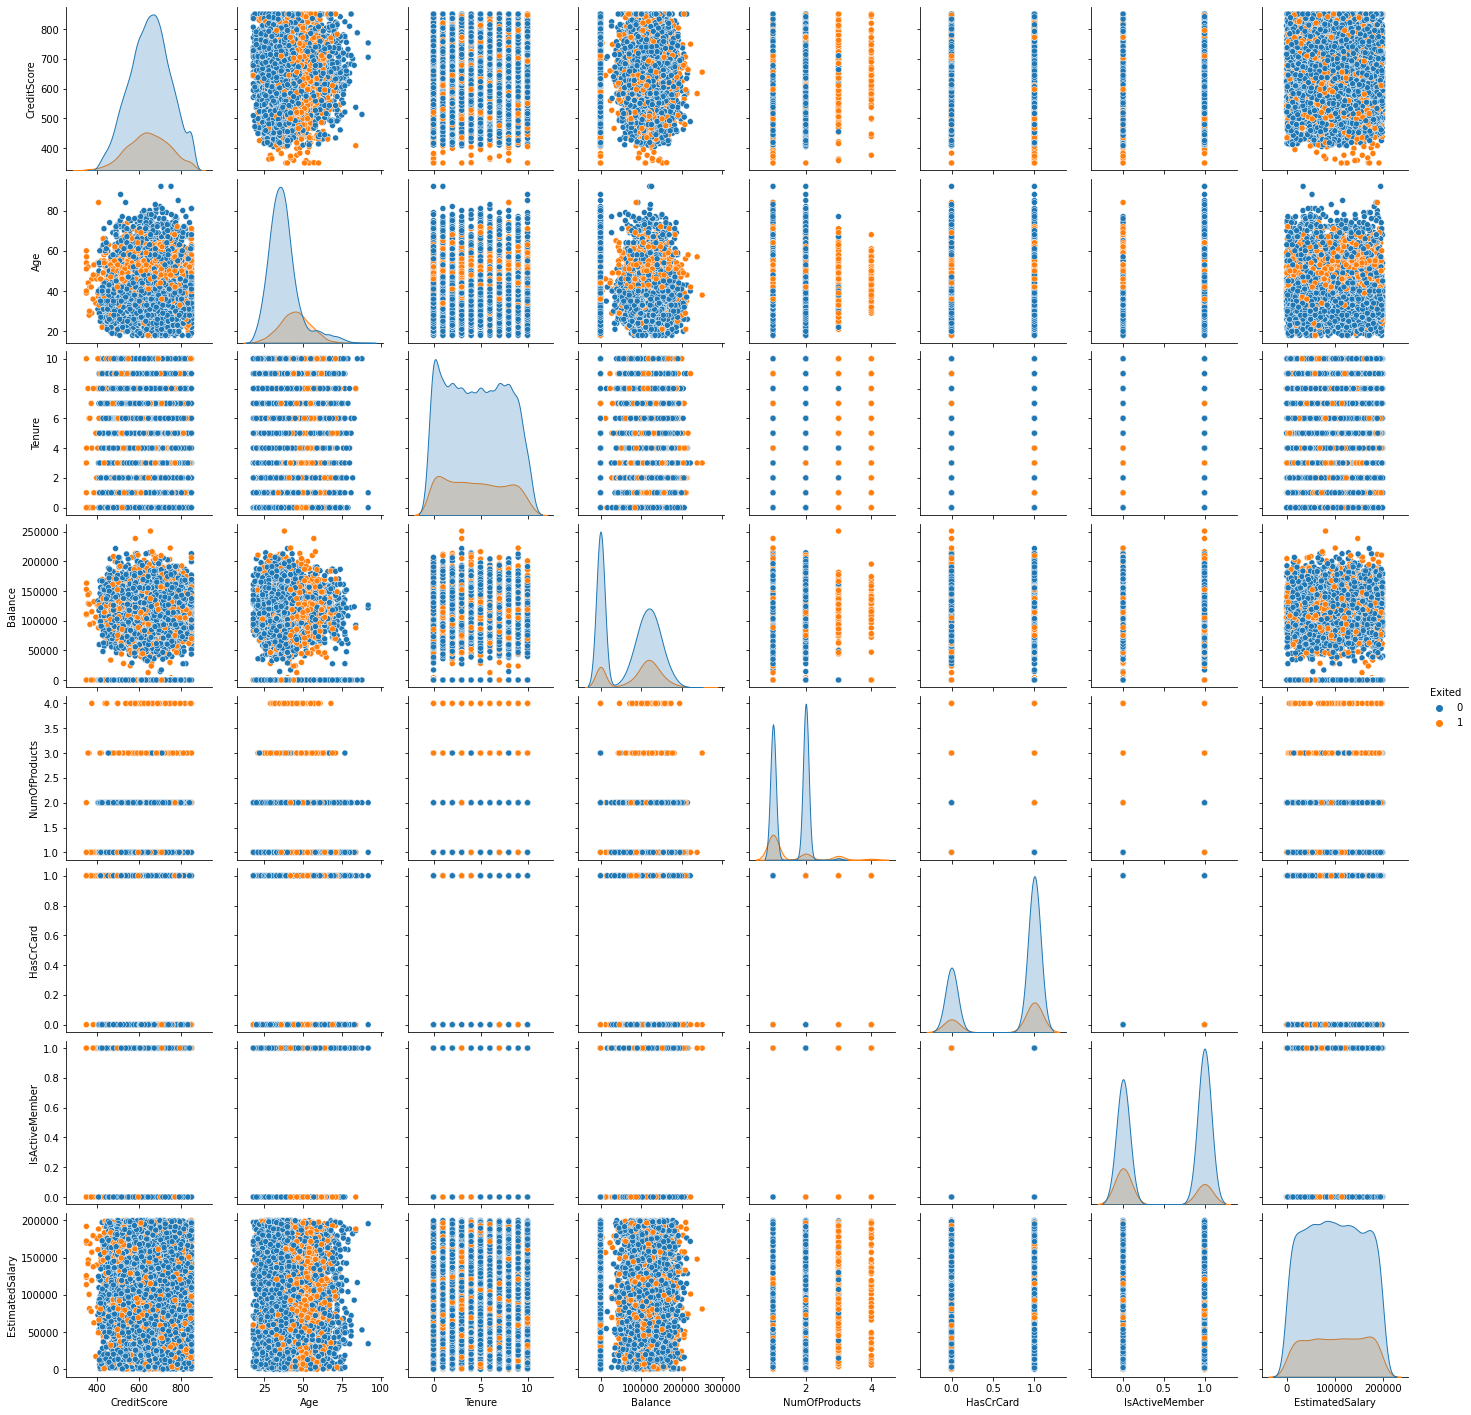

In [21]:
sns.pairplot(data, hue = 'Exited')

Видим, что нет признаков которые имели между собой сильную положительную связь. Поэтому оставляем набор признаков как есть.

Проверим на всякий случай датасет на аличие дубликатов:

In [22]:
data.duplicated().sum()

0

Явных дубликатов нет. Продолжим подготавливать данные.

* Прямое кодирование

Преобразуем наш датасет с помощью прямого кодирования, при этом учтем появление dummy-ловушек.

In [23]:
data = pd.get_dummies(data, drop_first=True)

Проверим полученные результаты:

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Получили новые столбцы с помощью прямого кодирования. Идем дальше.

* Стандартизация данных

Прежде чем начнем стандартизацию данных, разобьем наш датасет на три выборки:
* Обучающая; (60% датасета, так как отдельной тестовой выбокри у нас нет) 
* Валидационная; (20%)
* Тестовая. (20%)

In [25]:
train_data, split_data = train_test_split(data, test_size = .4, random_state = 12345)

In [26]:
valid_data, test_data = train_test_split(split_data, test_size = .5, random_state = 12345)

In [27]:
train_data.shape

(6000, 12)

In [28]:
valid_data.shape

(2000, 12)

In [29]:
test_data.shape

(2000, 12)

После того, как разбили наш датасет на необходимые выборки, разделим наборы на признаки и целевые признаки.

In [30]:
train_feature = train_data.drop('Exited', 1)
train_target = train_data.Exited

C:\Users\sanek\AppData\Local\Temp/ipykernel_9480/240444906.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_feature = train_data.drop('Exited', 1)


In [31]:
valid_feature = valid_data.drop('Exited', 1)
valid_target = valid_data.Exited

C:\Users\sanek\AppData\Local\Temp/ipykernel_9480/2607262216.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  valid_feature = valid_data.drop('Exited', 1)


In [32]:
test_feature = test_data.drop('Exited', 1)
test_target = test_data.Exited

C:\Users\sanek\AppData\Local\Temp/ipykernel_9480/3408681816.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_feature = test_data.drop('Exited', 1)


In [33]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [34]:
scaler = StandardScaler()
scaler.fit(train_feature[numeric])

StandardScaler()

In [35]:
train_feature[numeric] = scaler.transform(train_feature[numeric])
valid_feature[numeric] = scaler.transform(valid_feature[numeric])
test_feature[numeric] = scaler.transform(test_feature[numeric])

Посмотрим, что у нас получилось в итоге:

In [36]:
train_feature.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0


In [37]:
valid_feature.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-0.825373,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.503694,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.468729,0.438711,-0.891560,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.748053,1.239884,-0.891560,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.748053,-1.233163,0.830152,1,0,1.358533,0,1,1


In [38]:
test_feature.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-0.825373,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.426375,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.139662,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.748053,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.748053,0.615625,-0.891560,0,1,-1.070919,0,0,1


Данные стандартизированы.
## Вывод
В процессе подготовки данных выполнили следующие действия:

*   Пропуски в столбце `Tenure` заполнили нулями, посчитав, что это систематическая ошибка;
*   Удалили лишние для обучения модели признаки;
*   Произвели процедуру прямого кодирования для категориальных признаков;
*   Выполнили масштабирование данных для количественных признаков.

После того, как подоготовили данные, приступим к обучению.

# Исследование задачи<a id="3"></a>

Посмотрим на целевой признак. Определим количество уникальных значений в нем.

In [39]:
train_target.unique()

array([0, 1], dtype=int64)

В целевом признаке у нас всего два значения: 1 и 0 - наша задача сводится к бинарной классификации оттока клиентов (ушел или нет).

* Логистическая регрессия

In [40]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(train_feature, train_target)
prediction_logres = model.predict(valid_feature)
prediction_logres_freq = pd.Series(prediction_logres)
accuracy_score(valid_target, prediction_logres)

0.8025

Показатель accuracy дал хороший показатель - 80% верных ответов. 
А теперь проверим нашу модель на адекватность - сравним значение метрики accuracy со значением модели, которая прогнозируют наиболее частотный класс.

In [41]:
dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state=12345)
dummy_clf.fit(train_feature, train_target)
dummy_prediction = pd.Series(dummy_clf.predict(valid_feature))
accuracy_score(valid_target, dummy_prediction)

0.791

Видим, что константная модель дает приблизительно такие же результаты. 

Теперь посмотрим на модель случайного леса. Только для начала подберем наиболее оптимальные гиперпараметры. Сделаем это с помощью GridSearchCV.

In [42]:
parameters = {
    'n_estimators': range(10,121,10),
    'max_depth': range(1,13,2)
}

In [43]:
model = RandomForestClassifier(random_state=12345)
grid = GridSearchCV(model, parameters, cv = 5)
grid.fit(train_feature, train_target)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 13, 2),
                         'n_estimators': range(10, 121, 10)})

In [44]:
grid.best_params_

{'max_depth': 11, 'n_estimators': 120}

Получили наилучший набор гиперпараметров. Теперь обучим по ним нашу модель случайного леса.

* Случайный лес

In [45]:
model = RandomForestClassifier(random_state=12345, max_depth = 11, n_estimators = 120)
model.fit(train_feature, train_target)
rand_forest_predict = model.predict(valid_feature)
rand_forest_predict_freq = pd.Series(rand_forest_predict)
accuracy_score(valid_target, rand_forest_predict)

0.8605

И снова получили хорошее значение accuracy. Теперь построим графики частот предсказывания классов для каждой модели и посмотрим на частоту классов в исходных данных.

In [46]:
def draw_hist(s: pd.Series, title : str):
  s_freq = s.value_counts(normalize = True)
  plt.figure(figsize = (20,10))
  if title == 'logisticRegression':
    plt.title('График частот предсказанных классов с помощью Логистической регрессии'
    , fontsize = 15)
  elif title == 'RandomForest':
    plt.title('График частот предсказанных классов с помощью Случайного леса',
              fontsize = 15)
  elif title == 'dummy':
    plt.title('График частот предсказанных классов с помощью констатной модели',
              fontsize = 15)
  elif title == 'data':
    plt.title('График частот классов в исходных данных',
              fontsize = 15)
  else:
    plt.title('График частот классов в ' + title,
              fontsize = 15)
  plt.xlabel('классы', fontsize = 15)
  plt.ylabel('частота', fontsize = 15)
  s_freq.plot(kind = 'bar', ec = 'black', rot = 0)
  return s_freq

0    0.9125
1    0.0875
dtype: float64

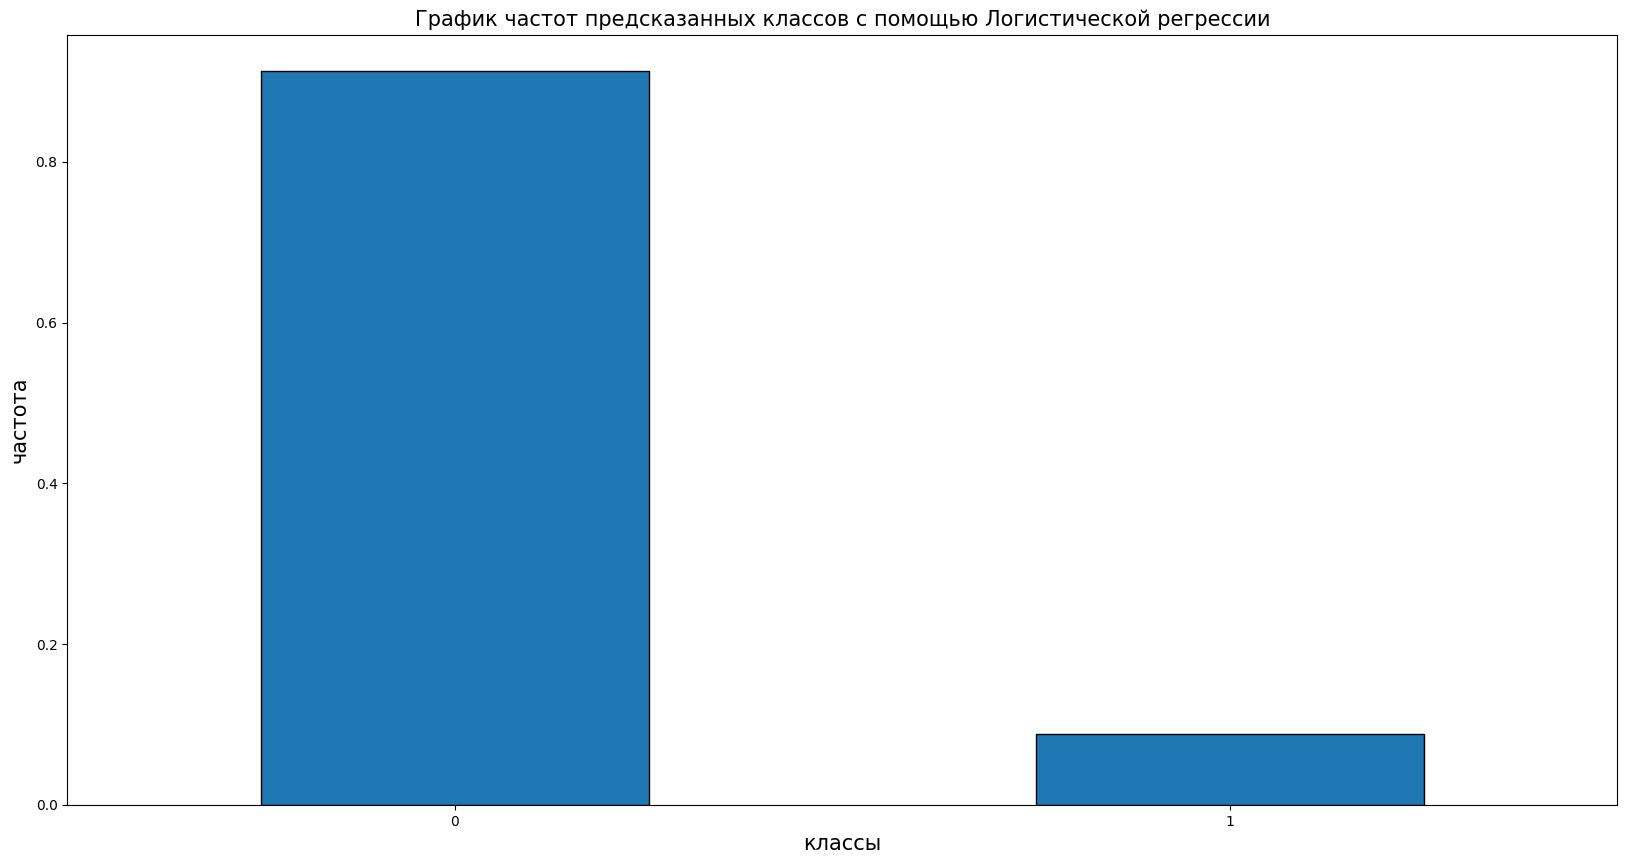

In [47]:
draw_hist(prediction_logres_freq, 'logisticRegression')

0    0.8815
1    0.1185
dtype: float64

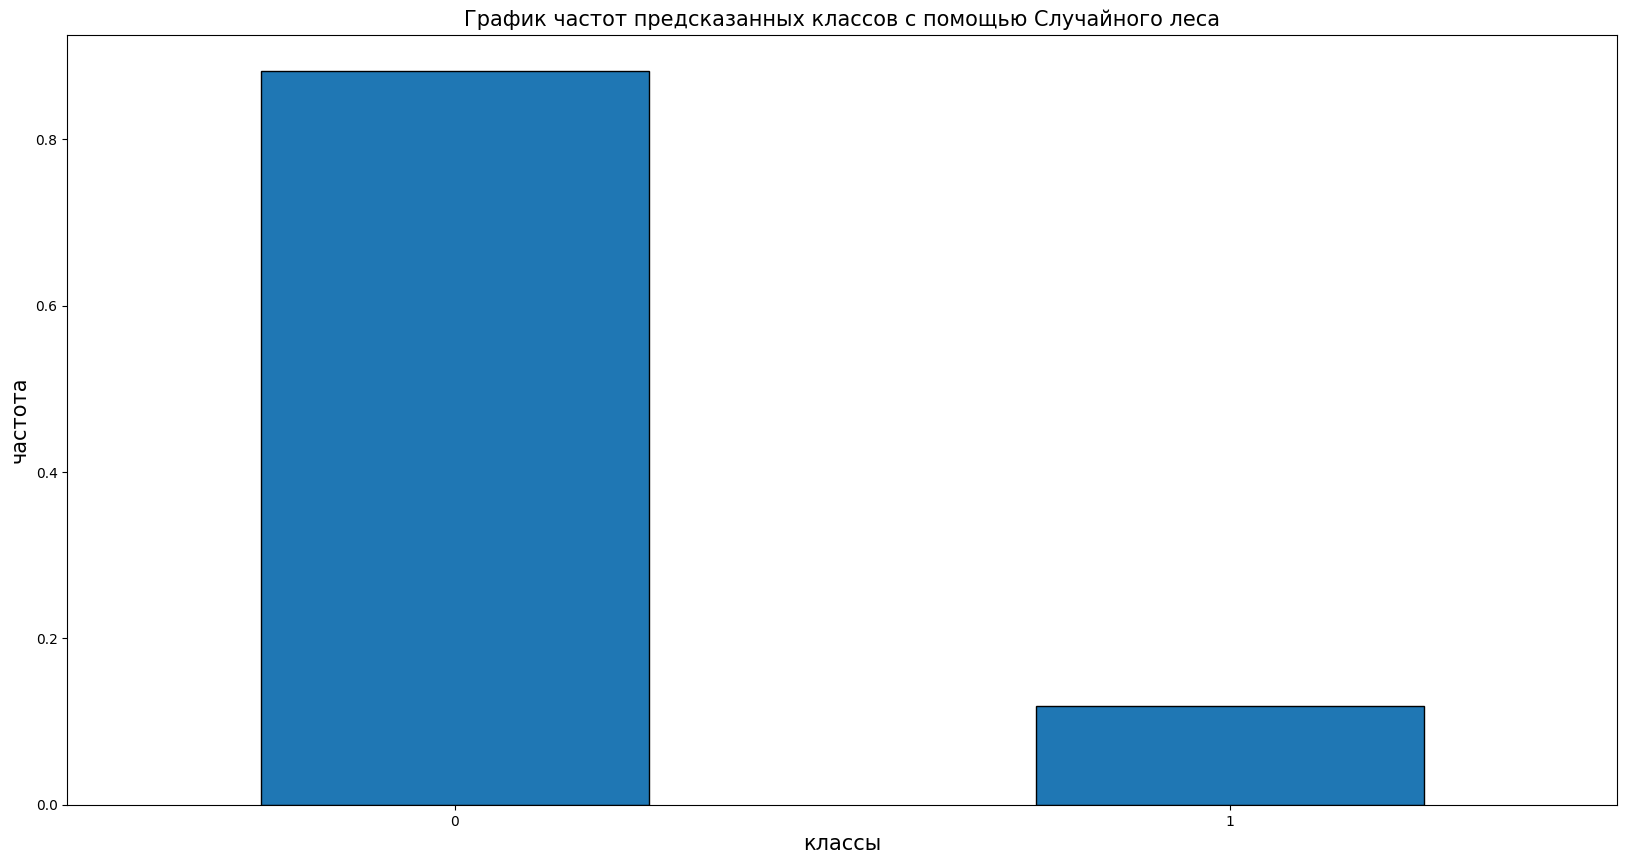

In [48]:
draw_hist(rand_forest_predict_freq, 'RandomForest')

0    0.7963
1    0.2037
Name: Exited, dtype: float64

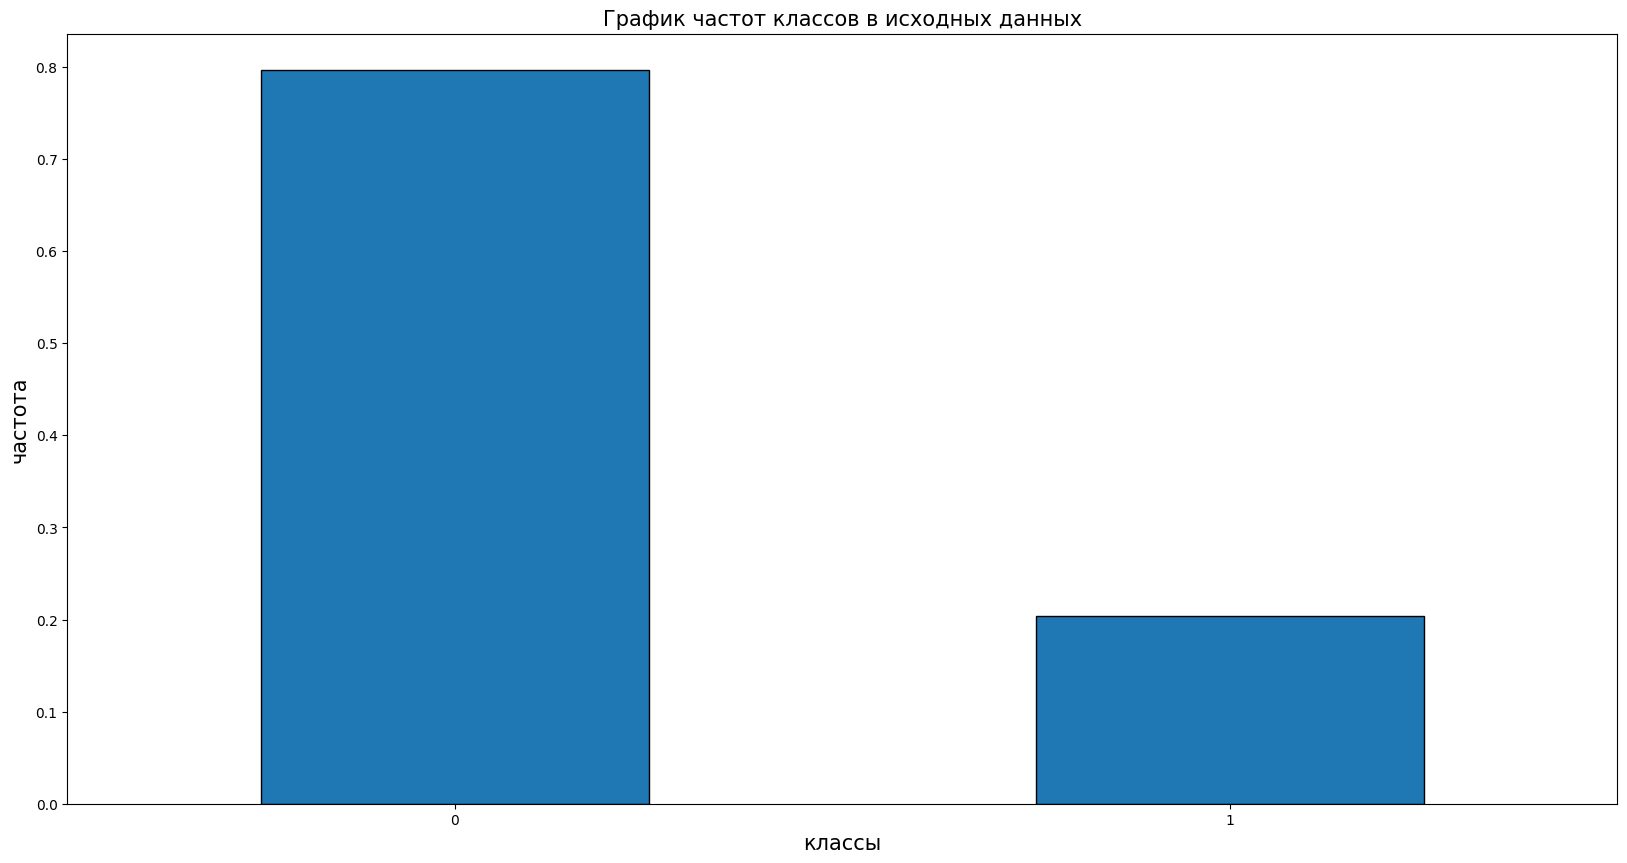

In [49]:
draw_hist(data.Exited, 'data')

## Вывод

Полученные результаты исследования задачи говорят нам следующее:
* метрика accuracy логистической регрессии и константной модели почти одинаковы
* после знакомства с частотой классов в исходных даннных обнаружили сильный дисбаланс классов (клиентов, которые пользуются услугами банка в 4 раза больше, чем клиентов, которые перестали быть клиентами банка). 
* метрика Accuracy не подходит для определения качества предсказания модели. Для этого будем пользоваться F1-мерой.

Таким образом необходимо разобраться с дисбалансом классов, оценить F1-меру.

# Борьба с дисбалансом<a id="4"></a>

Прежде всего посмотрим на матрицу ошибок для наших моделей.

* Матрица ошибок для Логистической регрессии

Text(0.5, 1.0, 'Матрица ошибок модели Логистической регрессии')

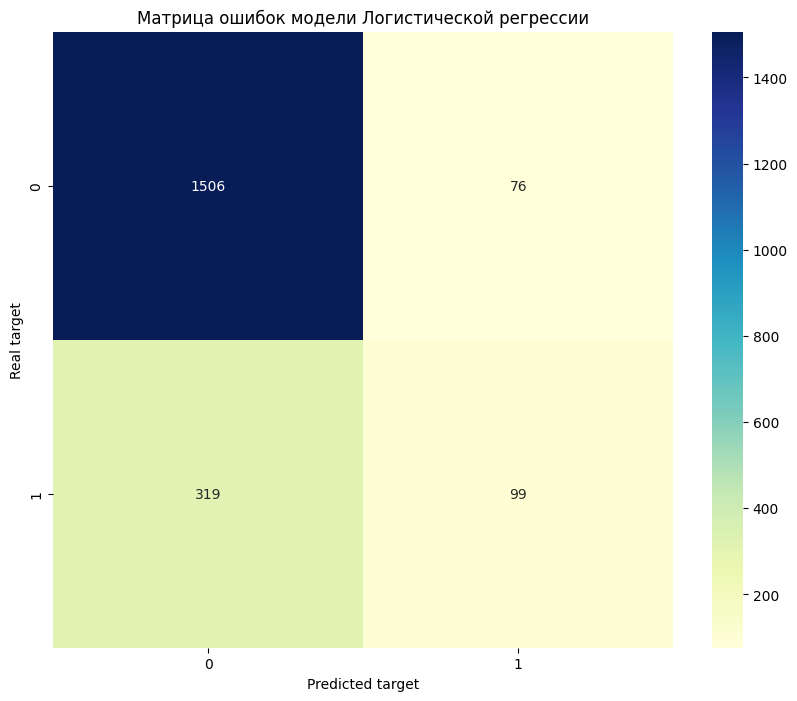

In [50]:
log_res_matrix = confusion_matrix(valid_target, prediction_logres)
plt.figure(figsize = (10,8))
sns.heatmap(log_res_matrix, annot = True, fmt='d', cmap="YlGnBu")
plt.ylabel('Real target')
plt.xlabel('Predicted target')
plt.title('Матрица ошибок модели Логистической регрессии')

Видим, модель предсказывает FN-ответы, больше, чем TP, это связано с дисбалансом классов. При этом видим, что модель прогнозирует часто отрицательный класс, в то время как доля TP-ответов крайне мала, а доля объектов, которые модель оишбочно посчитала как отрицательный класс больше.

* Матрица ошибок для Случайного леса

Text(0.5, 1.0, 'Матрица ошибок модели Случайного леса')

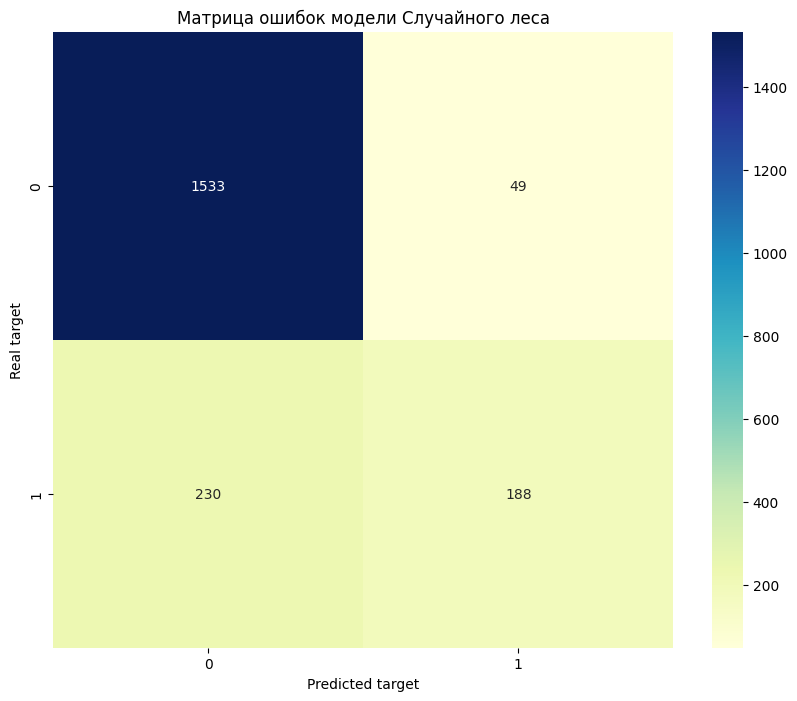

In [51]:
rand_for_matrix = confusion_matrix(valid_target, rand_forest_predict)
plt.figure(figsize = (10,8))
sns.heatmap(rand_for_matrix, annot = True, fmt='d', cmap="YlGnBu")
plt.ylabel('Real target')
plt.xlabel('Predicted target')
plt.title('Матрица ошибок модели Случайного леса')

Аналогичную ситуацию видим и с моделью случайного леса. 

Посчитаем F1-меру для наших моделей без учета дисбаланса классов.

* Логистическая регрессия

In [52]:
f1_score(valid_target, prediction_logres)

0.33389544688026984

* Случайный лес

In [53]:
f1_score(valid_target, rand_forest_predict)

0.5740458015267176

Видим, что для модели случайного леса с автоматически подобранными гиперпараметрами показатель F1-меры выше, чем у Логистической регрессии. Однако такого значения показателя не удовлетворяет требования заказчика.

Можно сказать, что на данный момент прогноз положительного класса не очень-то и положительный. 

Поэтому теперь расссмотрим различные способы для борьбы с дисбалансом классов.

Рассмотрим следующие методы борьбы с дисбалансом классов:

1.   Взвешивание классов;
2.   Upsampling;
3.   Downsampling;
4.   Настройка порога классификации.



Посчитаем значение AUC-ROC-score, чтобы понять, как у нас результаты модели отличются от случайной модели.
* Логистическая регрессия

In [54]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(train_feature, train_target)
probability_log = model.predict_proba(valid_feature)
probability_log_positive = probability_log[:,1]
print('ROC-AUC-score: {:.2f}'.format(roc_auc_score(valid_target, probability_log_positive)))

ROC-AUC-score: 0.76


* Случайный лес

In [55]:
model = RandomForestClassifier(random_state=12345, 
                               max_depth = 11,
                              n_estimators = 120)
model.fit(train_feature, train_target)
probability_forest = model.predict_proba(valid_feature)
probability_forest_positive = probability_log[:,1]
print('ROC-AUC-score: {:.2f}'.format(roc_auc_score(valid_target, probability_forest_positive)))

ROC-AUC-score: 0.76


Видим, что значение ROC-AUC-score больше случайной модели, однако полученные значения F1-меры мы получили из-за стандартного порога классификации, равной 0,5, отсюда мы получили результаты, которые не удовлетворяют заказчика. Метрика AUC-ROC-ысщку показывает, как у нас варьирутся доли FPR-TPR разного порога значения. По этой метрике видим, что в зависимости от порога классификации получаем разные доли положительных и отрицательных объектов класса.

Построим график ROC-кривой, чтобы определить текущую ситуацию с предсказаниями модели.

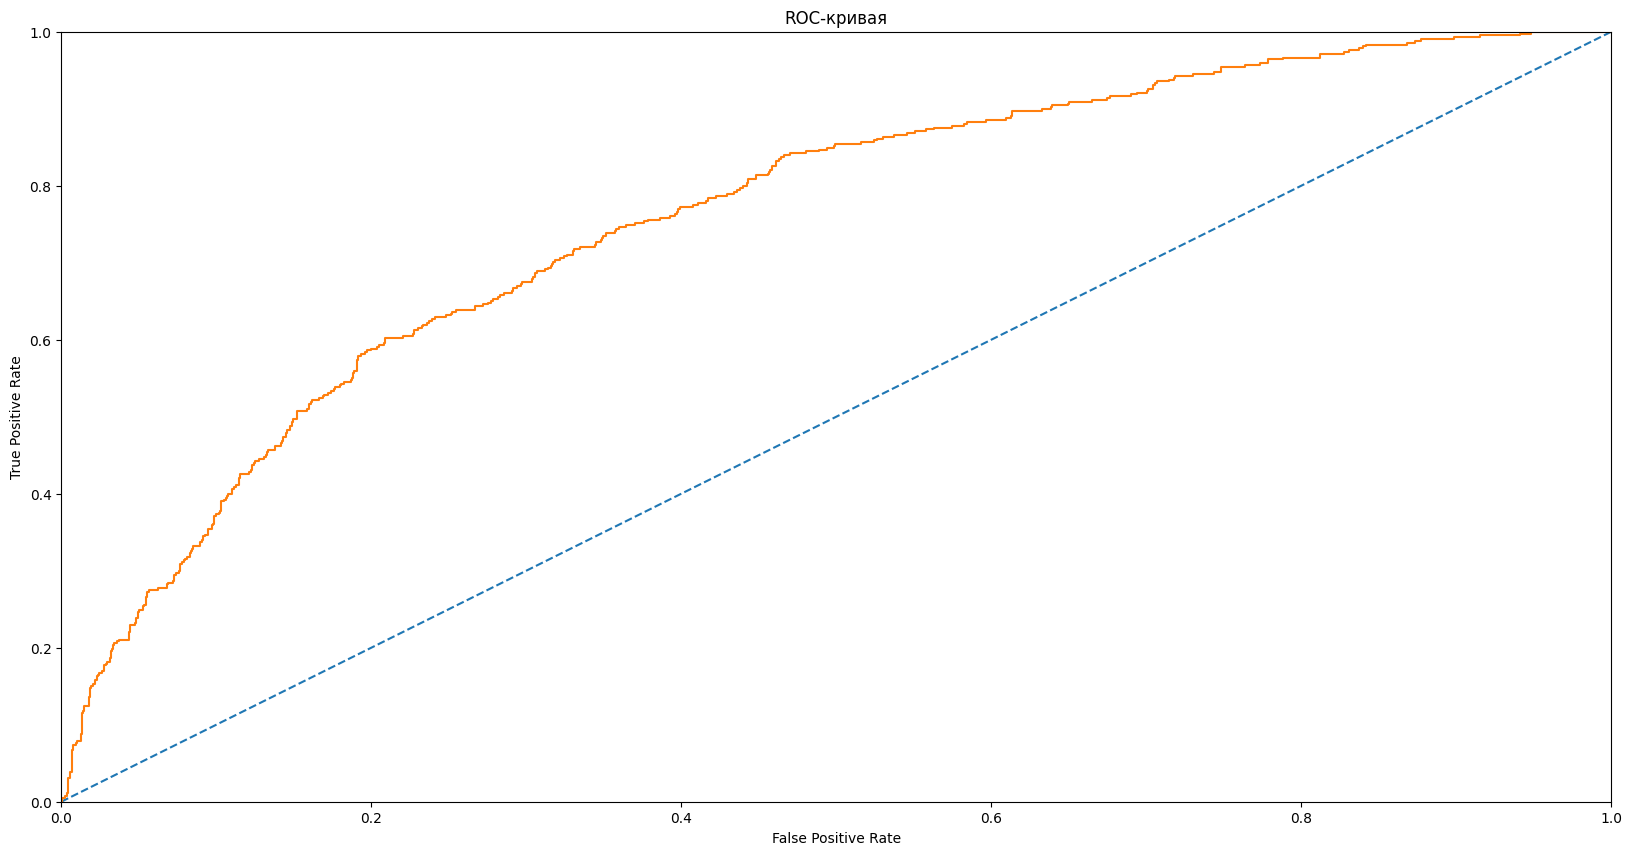

In [56]:
fpr, tpr, threshold = roc_curve(valid_target, probability_forest_positive)

plt.figure(figsize = (20,10))
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Видим, что при уменьшении порога классификации у нас растет доля FPR и FPR. Поэтому необходимо сбалансировать классы.

## Взвешивание классов

* Логистическая регрессия

In [57]:
%%time
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model.fit(train_feature, train_target)
prediction_valid = model.predict(valid_feature)
print('F1:', f1_score(valid_target, prediction_valid))

F1: 0.4888888888888888
Wall time: 15.9 ms


* Случайный лес

In [58]:
%%time
model = RandomForestClassifier(random_state=12345, max_depth = 11, n_estimators = 120, class_weight = 'balanced')
model.fit(train_feature, train_target)
prediction_valid = model.predict(valid_feature)
print('F1:', f1_score(valid_target, prediction_valid))

F1: 0.6078184110970997
Wall time: 1.14 s


Модель случайного леса с автоматически подобранными гиперпараметрами дает более высокий результат F1-меры по сравнению с Логистической регрессии. Более того, мы получили желаемого значение F1-меры для заказчика. При этом, разница обучения двух моделей незачительна.

Однако рассмотрим остальные способы борьбы с дисбаласном классов.

## Увеличение выборки

Напишем функцию, позволяющую увеличить обучающую выборку, а именно увеличить долю объектов положительного класса.

In [59]:
def model_upsample(feature: pd.DataFrame, 
                   target: pd.Series, 
                   repeat: int, 
                   model: str, 
                   check_feature: pd.DataFrame,
                   check_target: pd.Series):
  for count in range(1, repeat, 1):
    feature_negative = feature[target == 0]
    feature_positive = feature[target == 1]

    target_negative = target[target == 0]
    target_positive = target[target == 1]
    
    

    feature_upsample = pd.concat([feature_negative] + [feature_positive] * count)
    target_upsample = pd.concat([target_negative] + [target_positive] * count)

    feature_upsample, target_upsample = shuffle(feature_upsample, 
                                              target_upsample, 
                                              random_state = 12345)
  
    if model == 'logres':
      model = LogisticRegression(random_state = 12345, 
                                 solver = 'liblinear')
    elif model == 'randforest':
      model = RandomForestClassifier(random_state=12345, 
                                     max_depth = 11, 
                                     n_estimators = 120)
    model.fit(feature_upsample, target_upsample)
    prediction = model.predict(check_feature)
    print('Count:', count)
    print('F1-score: {:.2f}'.format(f1_score(check_target, prediction)))

In [60]:
model_upsample(train_feature, 
               train_target, 
               12, 
               'logres', 
               valid_feature, 
               valid_target)

Count: 1
F1-score: 0.33
Count: 2
F1-score: 0.47
Count: 3
F1-score: 0.50
Count: 4
F1-score: 0.49
Count: 5
F1-score: 0.48
Count: 6
F1-score: 0.47
Count: 7
F1-score: 0.45
Count: 8
F1-score: 0.44
Count: 9
F1-score: 0.43
Count: 10
F1-score: 0.42
Count: 11
F1-score: 0.41


* Случайный лес

In [61]:
model_upsample(train_feature, 
               train_target, 
               12, 
               'randforest', 
               valid_feature, 
               valid_target)

Count: 1
F1-score: 0.57
Count: 2
F1-score: 0.61
Count: 3
F1-score: 0.63
Count: 4
F1-score: 0.62
Count: 5
F1-score: 0.61
Count: 6
F1-score: 0.61
Count: 7
F1-score: 0.59
Count: 8
F1-score: 0.59
Count: 9
F1-score: 0.58
Count: 10
F1-score: 0.57
Count: 11
F1-score: 0.56


Здесь мы видим следующее:

Модель случайного леса с оптимальными гиперпараметрами дала результаты F1-меры лучше, чем Логистическая регрессия. При этом Логистическая регрессия снова дала плохой результат, который не удовлетворит заказчика. А Случайный лес снова показал результаты метрики, которые подойдут под требования заказчика.

Однако можно заметить следующее:

Чем больше доля объектов положительного класса в выборке, тем ниже значения метрики. Это связано с тем, что количество объектов положительного класса становится больше, чем объектов отрицательного класса - что дает нам снова дисбаланс классов, но теперь в сторону положительного класса.

Теперь посмотрим на альтернативный подход: уменьшение выборки. 

In [62]:
def model_upsample(feature: pd.DataFrame, 
                   target: pd.Series, 
                   repeat: int, 
                   model: str, 
                   check_feature: pd.DataFrame,
                   check_target: pd.Series):
    
    feature_negative = feature[target == 0]
    feature_positive = feature[target == 1]

    target_negative = target[target == 0]
    target_positive = target[target == 1]
    
    feature_upsample = pd.concat([feature_negative] + [feature_positive] * repeat)
    target_upsample = pd.concat([target_negative] + [target_positive] * repeat)
    
    feature_upsample, target_upsample = shuffle(feature_upsample, 
                                              target_upsample, 
                                              random_state = 12345)
  
    if model == 'logres':
      model = LogisticRegression(random_state = 12345, 
                                 solver = 'liblinear')
    elif model == 'randforest':
      model = RandomForestClassifier(random_state=12345, 
                                     max_depth = 11, 
                                     n_estimators = 120)
    
    model.fit(feature_upsample, target_upsample)
    prediction = model.predict(check_feature)
    probability = model.predict_proba(check_feature)
    probability_positive = probability[:,1]
    print('Repeat:', repeat)
    print('F1-score: {:.2f} | AUC-ROC-score: {:.2f}'.format(f1_score(check_target, prediction), 
                                                            roc_auc_score(check_target, probability_positive)))

    print('feature_negative: {0} | feature_positive: {1}'.format(len(feature_negative), len(feature_positive) * repeat))
    print('target_negative: {0}  | target_positive: {1}'.format(len(target_negative), len(target_positive) * repeat))

* Логистическая регрессия 

Увеличение выборки объектов положительного класса в 2  раза:

In [63]:
model_upsample(train_feature, 
               train_target, 
               2, 
               'logres', 
               valid_feature, 
               valid_target)

Repeat: 2
F1-score: 0.47 | AUC-ROC-score: 0.76
feature_negative: 4804 | feature_positive: 2392
target_negative: 4804  | target_positive: 2392


Увеличение выборки объектов положительного класса в 3  раза:

In [64]:
model_upsample(train_feature, 
               train_target, 
               3, 
               'logres', 
               valid_feature, 
               valid_target)

Repeat: 3
F1-score: 0.50 | AUC-ROC-score: 0.76
feature_negative: 4804 | feature_positive: 3588
target_negative: 4804  | target_positive: 3588


Увеличение выборки объектов положительного класса в 4 раза:

In [65]:
model_upsample(train_feature, 
               train_target, 
               4, 
               'logres', 
               valid_feature, 
               valid_target)

Repeat: 4
F1-score: 0.49 | AUC-ROC-score: 0.76
feature_negative: 4804 | feature_positive: 4784
target_negative: 4804  | target_positive: 4784


Увеличение выборки объектов положительного класса в 5 раз:

In [66]:
model_upsample(train_feature, 
               train_target, 
               5, 
               'logres', 
               valid_feature, 
               valid_target)

Repeat: 5
F1-score: 0.48 | AUC-ROC-score: 0.76
feature_negative: 4804 | feature_positive: 5980
target_negative: 4804  | target_positive: 5980


Видим, что в данном кейсе увеличение выборки в три раза для модели логистической регрессии даст наилучший результат. При этом классы будут сбалансированы при увеличении выборки в 4 раза, но при этом теряем в F1-мере на 0.1. Предположительно, это связано со стандартным порогом классификации.

* Модель случайного леса:

Увеличение выборки объектов положительного класса в 2 раза:

In [67]:
model_upsample(train_feature, 
               train_target, 
               2, 
               'randforest', 
               valid_feature, 
               valid_target)

Repeat: 2
F1-score: 0.61 | AUC-ROC-score: 0.85
feature_negative: 4804 | feature_positive: 2392
target_negative: 4804  | target_positive: 2392


Увеличение выборки объектов положительного класса в 3 раза:

In [68]:
model_upsample(train_feature, 
               train_target, 
               3, 
               'randforest', 
               valid_feature, 
               valid_target)

Repeat: 3
F1-score: 0.63 | AUC-ROC-score: 0.85
feature_negative: 4804 | feature_positive: 3588
target_negative: 4804  | target_positive: 3588


Увеличение выборки объектов положительного класса в 4 раза:

In [69]:
model_upsample(train_feature, 
               train_target, 
               4, 
               'randforest', 
               valid_feature, 
               valid_target)

Repeat: 4
F1-score: 0.62 | AUC-ROC-score: 0.85
feature_negative: 4804 | feature_positive: 4784
target_negative: 4804  | target_positive: 4784


Увеличение выборки объектов положительного класса в 5 раз:

In [70]:
model_upsample(train_feature, 
               train_target, 
               5, 
               'randforest', 
               valid_feature, 
               valid_target)

Repeat: 5
F1-score: 0.61 | AUC-ROC-score: 0.85
feature_negative: 4804 | feature_positive: 5980
target_negative: 4804  | target_positive: 5980


Аналогичную ситуацию видим и с моделью Случайного Леса

## Уменьшение выборки

In [71]:
def model_downsample(feature: pd.DataFrame, 
                   target: pd.Series, 
                   fraction: float, 
                   model: str, 
                   check_feature: pd.DataFrame,
                   check_target: pd.Series):
  for count in np.arange(0.1, fraction, 0.05):
    feature_negative = feature[target == 0]
    feature_positive = feature[target == 1]

    target_negative = target[target == 0]
    target_positive = target[target == 1]

    feature_downsample = pd.concat(
        [feature_negative.sample(frac = count, 
                                 random_state = 12345)] + [feature_positive])
    
    target_downsample = pd.concat(
        [target_negative.sample(frac = count, 
                                random_state = 12345)] + [target_positive])

    feature_downsample, target_downsample = shuffle(feature_downsample, 
                                              target_downsample, 
                                              random_state = 12345)
  
    if model == 'logres':
      model = LogisticRegression(random_state = 12345, 
                                 solver = 'liblinear')
    elif model == 'randforest':
      model = RandomForestClassifier(random_state=12345, 
                                     max_depth = 11, 
                                     n_estimators = 120)
    model.fit(feature_downsample, target_downsample)
    prediction = model.predict(check_feature)
    print('Fraction: {:.2f}'.format(count))
    print('F1-score: {:.2f}'.format(f1_score(check_target, prediction)))

In [72]:
model_downsample(train_feature, 
               train_target, 
               0.5, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.10
F1-score: 0.43
Fraction: 0.15
F1-score: 0.46
Fraction: 0.20
F1-score: 0.48
Fraction: 0.25
F1-score: 0.49
Fraction: 0.30
F1-score: 0.50
Fraction: 0.35
F1-score: 0.49
Fraction: 0.40
F1-score: 0.51
Fraction: 0.45
F1-score: 0.49


In [73]:
model_downsample(train_feature, 
               train_target, 
               0.7, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.10
F1-score: 0.46
Fraction: 0.15
F1-score: 0.52
Fraction: 0.20
F1-score: 0.57
Fraction: 0.25
F1-score: 0.60
Fraction: 0.30
F1-score: 0.61
Fraction: 0.35
F1-score: 0.61
Fraction: 0.40
F1-score: 0.63
Fraction: 0.45
F1-score: 0.63
Fraction: 0.50
F1-score: 0.63
Fraction: 0.55
F1-score: 0.63
Fraction: 0.60
F1-score: 0.63
Fraction: 0.65
F1-score: 0.61


В результате видим следующее:
Логистическая регрессия снова дала результаты, которые нам не подходят. 

Модель случайного леса показала хорошие результаты, практически на уровне метода увеличения выборки. Однако, как мы видим, чем выше доля от исходных данных, тем ниже значение F1-меры, это связано с тем, что при приближении к доле, равной 1, мы вернемся к объему исходных данных, с которым мы работали до уменьшения выборки.

Теперь посмотрим на следующий способ: изменение порога классификации.

In [74]:
def model_downsample(feature: pd.DataFrame, 
                   target: pd.Series, 
                   fraction: float, 
                   model: str, 
                   check_feature: pd.DataFrame,
                   check_target: pd.Series):

    feature_negative = feature[target == 0]
    feature_positive = feature[target == 1]

    target_negative = target[target == 0]
    target_positive = target[target == 1]
    
    len_feature_negative = len(feature_negative.sample(frac = fraction, 
                                                       random_state = 12345))
    
    len_target_negative = len(target_negative.sample(frac = fraction, 
                                                       random_state = 12345))
    
    feature_downsample = pd.concat(
        [feature_negative.sample(frac = fraction, 
                                 random_state = 12345)] + [feature_positive])
    
    target_downsample = pd.concat(
        [target_negative.sample(frac = fraction, 
                                random_state = 12345)] + [target_positive])

    feature_downsample, target_downsample = shuffle(feature_downsample, 
                                              target_downsample, 
                                              random_state = 12345)
  
    if model == 'logres':
      model = LogisticRegression(random_state = 12345, 
                                 solver = 'liblinear')
    elif model == 'randforest':
      model = RandomForestClassifier(random_state=12345, 
                                     max_depth = 11, 
                                     n_estimators = 120)
    model.fit(feature_downsample, target_downsample)
    prediction = model.predict(check_feature)
    probabilty = model.predict_proba(check_feature)
    probabilty_positive = probabilty[:,1]
    print('Fraction: {:.2f}'.format(fraction))
    print('F1-score: {:.2f} | AUC-ROC-score {:.2f}'.format(
        f1_score(check_target, prediction),
        roc_auc_score(check_target, probabilty_positive)))
    print('feature_negative: {} | feature_positive: {}'.format(len_feature_negative, len(feature_positive)))
    print('target_negative: {}  | target_positive: {}'.format(len_target_negative, len(target_positive)))

* Модель Логистической регрессии

Доля выборки объектов отрицательного класса - 0.1

In [75]:
model_downsample(train_feature, 
               train_target, 
               0.1, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.10
F1-score: 0.43 | AUC-ROC-score 0.76
feature_negative: 480 | feature_positive: 1196
target_negative: 480  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.2

In [76]:
model_downsample(train_feature, 
               train_target, 
               0.2, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.20
F1-score: 0.48 | AUC-ROC-score 0.76
feature_negative: 961 | feature_positive: 1196
target_negative: 961  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.3

In [77]:
model_downsample(train_feature, 
               train_target, 
               0.3, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.30
F1-score: 0.50 | AUC-ROC-score 0.76
feature_negative: 1441 | feature_positive: 1196
target_negative: 1441  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.4

In [78]:
model_downsample(train_feature, 
               train_target, 
               0.4, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.40
F1-score: 0.51 | AUC-ROC-score 0.76
feature_negative: 1922 | feature_positive: 1196
target_negative: 1922  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.5

In [79]:
model_downsample(train_feature, 
               train_target, 
               0.5, 
               'logres', 
               valid_feature, 
               valid_target)

Fraction: 0.50
F1-score: 0.47 | AUC-ROC-score 0.76
feature_negative: 2402 | feature_positive: 1196
target_negative: 2402  | target_positive: 1196


При использовании метода уменьшении выборки классы становятся сбалансированными при доле выборки отрицательного класса, равной 0.3

* Модель случайного леса:

Доля выборки объектов отрицательного класса - 0.1

In [80]:
model_downsample(train_feature, 
               train_target, 
               0.1, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.10
F1-score: 0.46 | AUC-ROC-score 0.83
feature_negative: 480 | feature_positive: 1196
target_negative: 480  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.2

In [81]:
model_downsample(train_feature, 
               train_target, 
               0.2, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.20
F1-score: 0.57 | AUC-ROC-score 0.84
feature_negative: 961 | feature_positive: 1196
target_negative: 961  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.3

In [82]:
model_downsample(train_feature, 
               train_target, 
               0.3, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.30
F1-score: 0.61 | AUC-ROC-score 0.85
feature_negative: 1441 | feature_positive: 1196
target_negative: 1441  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.4

In [83]:
model_downsample(train_feature, 
               train_target, 
               0.4, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.40
F1-score: 0.63 | AUC-ROC-score 0.85
feature_negative: 1922 | feature_positive: 1196
target_negative: 1922  | target_positive: 1196


Доля выборки объектов отрицательного класса - 0.5

In [84]:
model_downsample(train_feature, 
               train_target, 
               0.5, 
               'randforest', 
               valid_feature, 
               valid_target)

Fraction: 0.50
F1-score: 0.63 | AUC-ROC-score 0.85
feature_negative: 2402 | feature_positive: 1196
target_negative: 2402  | target_positive: 1196


Аналогичную ситуацию видим и с моделью случайного леса.

## Изменение порога классификации

In [85]:
def predict_proba(feature: pd.DataFrame, 
                  target: pd.Series, 
                  range: float,
                  model:str,
                  check_feature: pd.DataFrame,
                  check_target: pd.Series):
  
  if model == 'logres':
    model = LogisticRegression(random_state = 12345, 
                               solver = 'liblinear')
  elif model == 'randforest':
    model = RandomForestClassifier(random_state = 12345,
                                  max_depth = 11, 
                                  n_estimators = 120)
  model.fit(feature, target)
  pred_probability = model.predict_proba(check_feature)
  pred_probability_positive = pred_probability[:,1]
  for treshold in np.arange(0, range, 0.02):
    predicted_valid = pred_probability_positive > treshold
    precision = precision_score(check_target, predicted_valid)
    recall = recall_score(check_target, predicted_valid)
    f1 = f1_score(check_target, predicted_valid)
    auc = roc_auc_score(check_target, pred_probability_positive)
    print('Treshold: {:.2f}  | Precision: {:.3f} | Recall: {:.3f} | F1: {:.2f} | AUC: {:.2f}'.format(treshold, precision, recall, f1, auc))
  precision, recall, treshold = precision_recall_curve(check_target, pred_probability_positive)
  plt.figure(figsize = (20,10))
  plt.step(recall, precision, where = 'post')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim(0,1)
  plt.xlim(0,1)
  plt.title('PR-кривая')
  plt.show()

* Логистическая регрессия

Treshold: 0.00  | Precision: 0.209 | Recall: 1.000 | F1: 0.35 | AUC: 0.76
Treshold: 0.02  | Precision: 0.211 | Recall: 1.000 | F1: 0.35 | AUC: 0.76
Treshold: 0.04  | Precision: 0.227 | Recall: 0.990 | F1: 0.37 | AUC: 0.76
Treshold: 0.06  | Precision: 0.245 | Recall: 0.967 | F1: 0.39 | AUC: 0.76
Treshold: 0.08  | Precision: 0.258 | Recall: 0.926 | F1: 0.40 | AUC: 0.76
Treshold: 0.10  | Precision: 0.276 | Recall: 0.897 | F1: 0.42 | AUC: 0.76
Treshold: 0.12  | Precision: 0.299 | Recall: 0.864 | F1: 0.44 | AUC: 0.76
Treshold: 0.14  | Precision: 0.321 | Recall: 0.813 | F1: 0.46 | AUC: 0.76
Treshold: 0.16  | Precision: 0.337 | Recall: 0.773 | F1: 0.47 | AUC: 0.76
Treshold: 0.18  | Precision: 0.356 | Recall: 0.730 | F1: 0.48 | AUC: 0.76
Treshold: 0.20  | Precision: 0.371 | Recall: 0.675 | F1: 0.48 | AUC: 0.76
Treshold: 0.22  | Precision: 0.389 | Recall: 0.639 | F1: 0.48 | AUC: 0.76
Treshold: 0.24  | Precision: 0.412 | Recall: 0.615 | F1: 0.49 | AUC: 0.76
Treshold: 0.26  | Precision: 0.434 | R

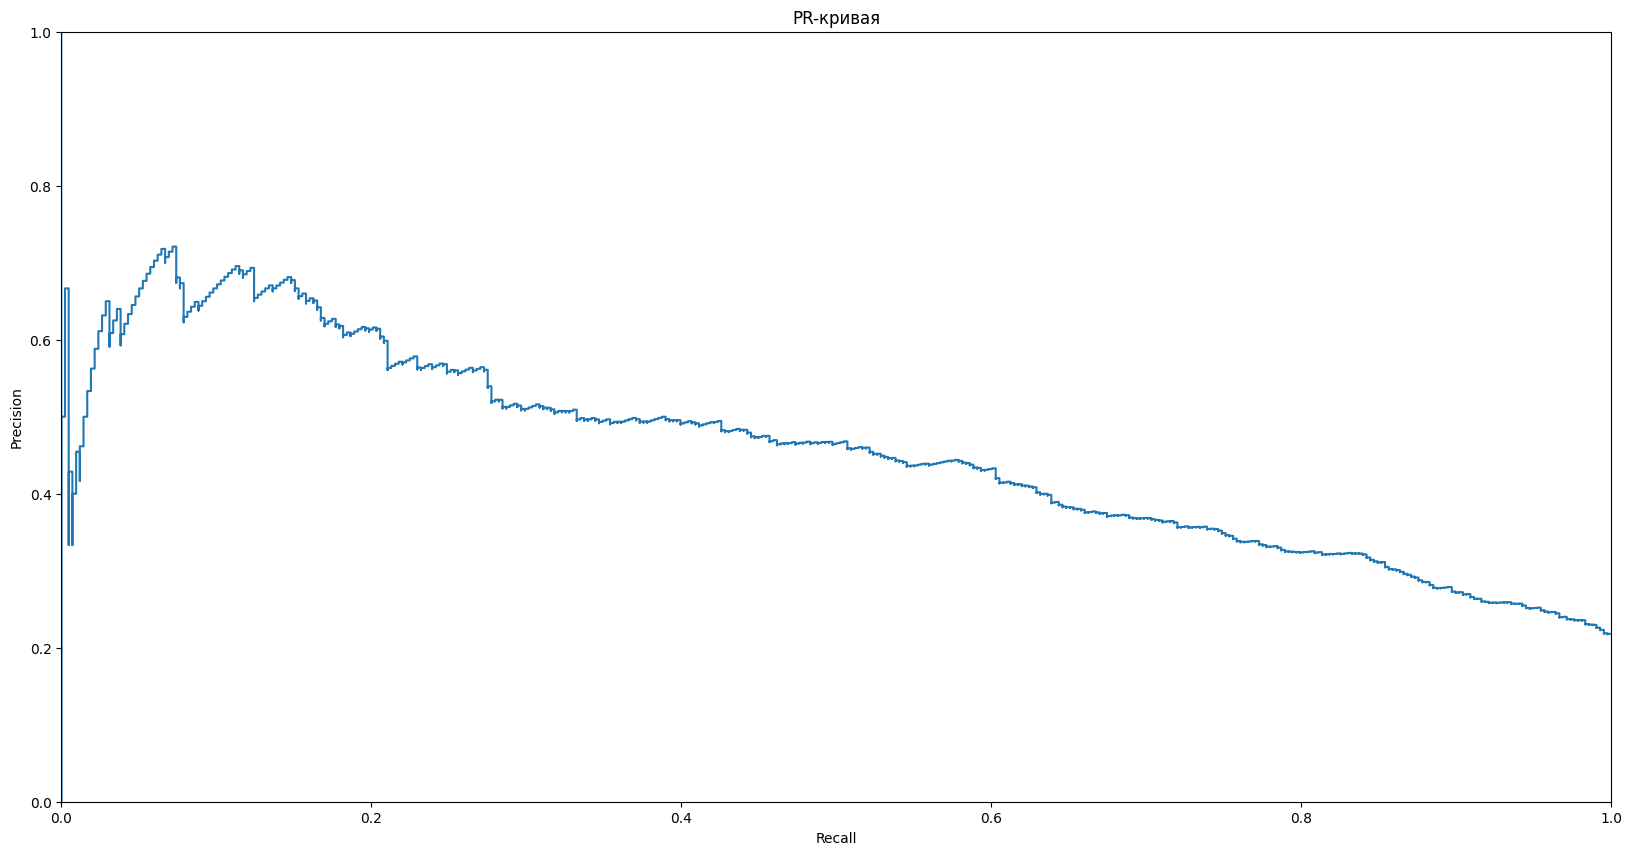

In [86]:
predict_proba(train_feature,
              train_target, 
              0.3,
              'logres',
              valid_feature,
              valid_target)

* Случайный лес

Treshold: 0.00  | Precision: 0.209 | Recall: 1.000 | F1: 0.35 | AUC: 0.85
Treshold: 0.02  | Precision: 0.227 | Recall: 0.995 | F1: 0.37 | AUC: 0.85
Treshold: 0.04  | Precision: 0.252 | Recall: 0.967 | F1: 0.40 | AUC: 0.85
Treshold: 0.06  | Precision: 0.276 | Recall: 0.940 | F1: 0.43 | AUC: 0.85
Treshold: 0.08  | Precision: 0.301 | Recall: 0.916 | F1: 0.45 | AUC: 0.85
Treshold: 0.10  | Precision: 0.332 | Recall: 0.888 | F1: 0.48 | AUC: 0.85
Treshold: 0.12  | Precision: 0.361 | Recall: 0.854 | F1: 0.51 | AUC: 0.85
Treshold: 0.14  | Precision: 0.391 | Recall: 0.823 | F1: 0.53 | AUC: 0.85
Treshold: 0.16  | Precision: 0.425 | Recall: 0.801 | F1: 0.56 | AUC: 0.85
Treshold: 0.18  | Precision: 0.451 | Recall: 0.770 | F1: 0.57 | AUC: 0.85
Treshold: 0.20  | Precision: 0.482 | Recall: 0.754 | F1: 0.59 | AUC: 0.85
Treshold: 0.22  | Precision: 0.507 | Recall: 0.737 | F1: 0.60 | AUC: 0.85
Treshold: 0.24  | Precision: 0.535 | Recall: 0.713 | F1: 0.61 | AUC: 0.85
Treshold: 0.26  | Precision: 0.564 | R

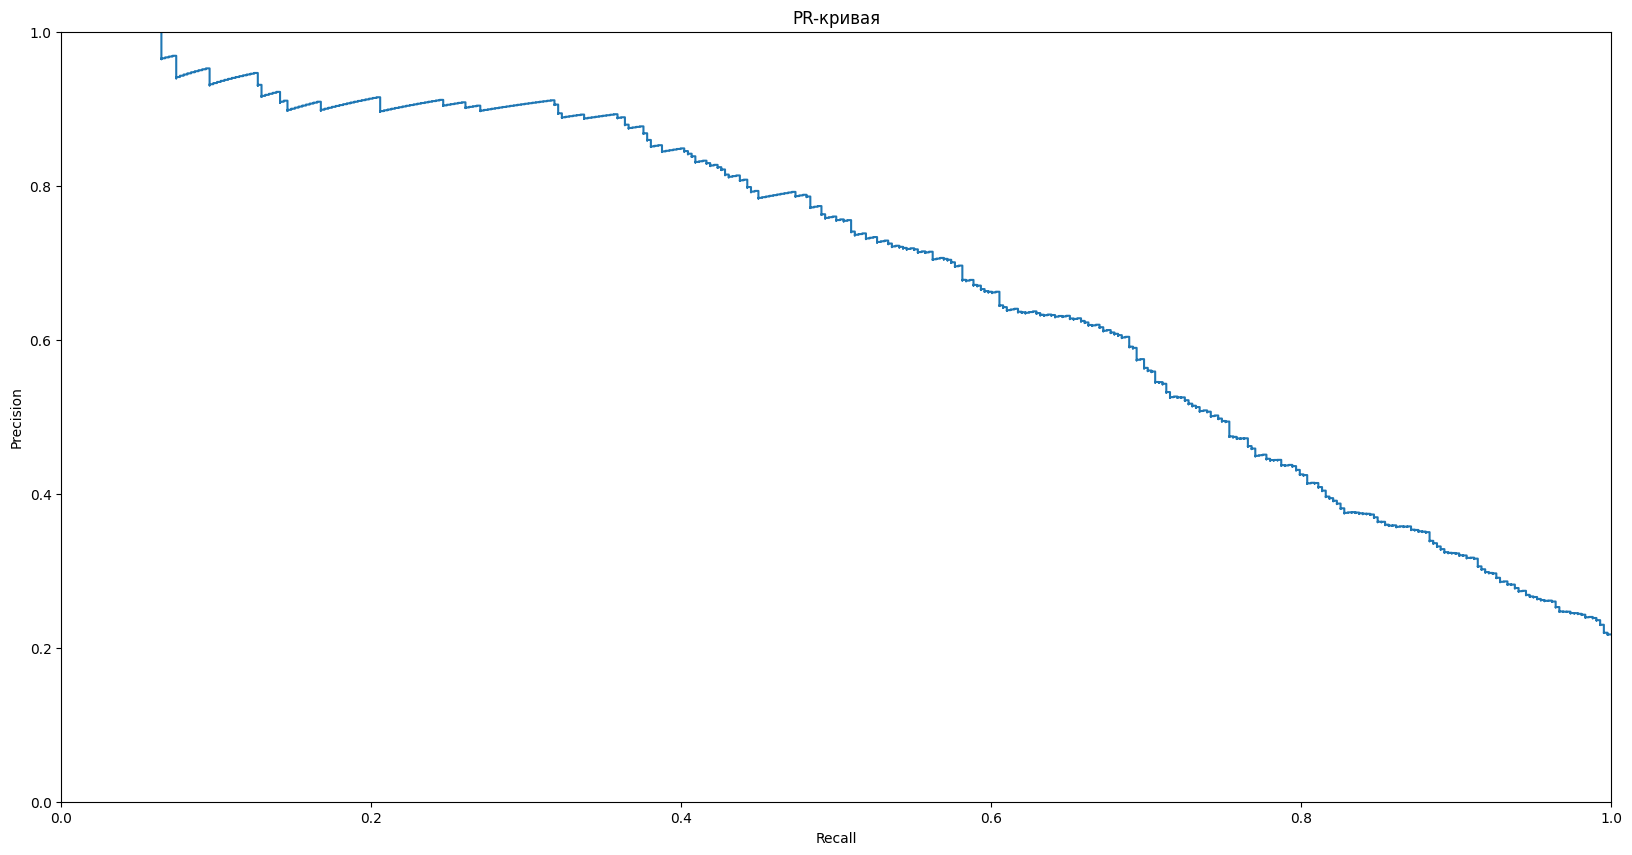

In [87]:
predict_proba(train_feature,
              train_target, 
              0.5,
              'randforest',
              valid_feature,
              valid_target)

В результате изменения порога классификации заметили следующее: 

* Логистчиеская регрессия показала результаты, которые нам не подходят для поставленной задачи;
* Случайный лес при изменении порога классификации дает более лучшие показатели, более того, данные способ борьбы с дисбалансом классов дал самый лучший показатель метрики F1-score: при пороговом значении в 0.3 получили значение метрики, равной 0,64 - это лучший показатель среди всех полученных результатов при использовании различных способов борьбы с классами.

## Вывод

В процессе борьбы с классами получили следующие результаты:
* Логистическая регрессия ведет себя хуже, F1-мера при использовании разных методов давала не больше 0.5;
* Случайный лес при заранее определенных гиперпараметрах в каждом методе показала себя лучше. При этом ее результаты удовлетворяют требования ТЗ: F1-мера больше или равная 0.59
* Метод взвешенных классов - наиболее простой способ устранения дисбаланса классов, однака полученный результат F1-меры не самый лучший среди всех остальных остальных способов - "золотая середина";
* Метод увеличения выборки: прост в реализации, хорошие результаты, однако нужно определять оптимальную величину объектов положительного класса, так как можем столкнуться с дисбалансом в сторону положительного класса;
* Аналогично метод уменьшения выборки: хорошие результаты, но необходимо учитывать долю исходных данных, с которой будем обучать нашу модель. Чем больше доля - тем ближе мы приближаемся к исходным результатам и наоборот - чем меньше доля, тем велика вероятность того, что получим дисбаланс классов.
* Метод изменения порога: самые лучшие результаты, метод позволяет изменять границу получения положительного класса моделью, однако необходимо определить: что для нас важнее: полнота или точность?
Чем больше порог - тем выше точность, но меньше полнота и наоборот. Необходимо подобрать оптимальное значение порога, чтобы достичь макимизации полносты и точности.
* Лучшая модель: модель **Случайного леса**
* Метод взвешивания классов:
  * Точность: 0.62
* Метод увеличения выборки:
  * Точность: 0.628
  * Увеличение количества объектов: в 3 раза
* Метод уменшения выборки:
  * Точность: 0.629
  * Уменьшение количества объектов: в 4 раза
* Метод изменения порога классификации:
  * Точность: 0.64
  * Порог классификации: 0.3 

Таким образом, для финального тестирования возьмем следующий алгоритм:
* Алгоритм **случайного леса**, гиперпараметры определили с помощью `GridSearchCV`;
* Для решения проблемы дисбаланса классов воспользуемся методом **Изменения порога классификации**
* Порог классификации: 0.3

Теперь проведем финальное тестирование.

## Тестирование модели<a id="5"></a>

Прежде чем проведем тестирование на тестовой выборке, объединим валидационную и обучающую выборку.

In [88]:
train_feature_concat = pd.concat([train_feature] + [valid_feature], ignore_index = True)

In [89]:
train_feature_concat

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
1,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
2,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1
3,-1.457915,-1.417129,0.461340,-1.233163,0.830152,1,0,-1.071061,0,0,1
4,0.130961,-1.132419,-0.825373,1.140475,-0.891560,0,0,1.524268,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7995,0.276349,-1.417129,0.461340,0.617449,0.830152,0,1,0.628182,0,0,0
7996,-0.211738,0.291132,-0.182016,0.797229,-0.891560,1,0,0.026002,0,0,1
7997,-1.364452,0.006422,0.461340,-1.233163,0.830152,0,1,-1.249087,0,0,0
7998,1.075979,2.663716,-0.182016,-1.233163,2.551864,1,1,-0.111107,0,0,1


In [90]:
train_target_concat = pd.concat([train_target] + [valid_target], ignore_index = True)

In [91]:
train_target_concat

0       0
1       0
2       0
3       0
4       0
       ..
7995    0
7996    0
7997    0
7998    0
7999    1
Name: Exited, Length: 8000, dtype: int64

Теперь проведем тестирование на тестовой выборке:

In [92]:
model = RandomForestClassifier(random_state = 12345, 
                               max_depth = 11,
                               n_estimators = 120)
model.fit(train_feature_concat, train_target_concat)
probability_value = model.predict_proba(test_feature)
probability_value_positive = probability_value[:,1]
predicted_value = probability_value_positive > 0.3
print('F1: {:.2f}'.format(f1_score(test_target, predicted_value)))

F1: 0.61


Полученный результат F1-меры удовлетворяет ТЗ (не менее 0.59). Однако здесь мы проверяли результаты в том случае, если объединить обучающую и валидационную выборки. Предположительно, чем больше новая обучающая выборка, тем больше у нас количество истинно положительных и ложнопожительных результатов. 

В дальнейшем мы рассмотрим случай, если бы мы использовали исходный размер обучающей выборки без добавления в нее валидационной выборки.

Посмотрим на величину AUC-ROC:

In [93]:
print("AUC_ROC-score: {:.2f}".format(roc_auc_score(test_target, probability_value_positive)))

AUC_ROC-score: 0.86


Видим, что величина AUC-ROC больше случайной модели.

Теперь посмотрим случай, если мы не будем объединять обучающую и валидационную выборки вместе.

In [94]:
model = RandomForestClassifier(random_state = 12345, 
                               max_depth = 11,
                               n_estimators = 120)
model.fit(train_feature, train_target)
probability_value = model.predict_proba(test_feature)
probability_value_positive = probability_value[:,1]
predicted_value = probability_value_positive > 0.3
print('F1: {:.2f}'.format(f1_score(test_target, predicted_value)))

F1: 0.62


Видим, что F1-мера стала лучше за счет исходной обучающей выборки. С заданным порогом классификации (вероятность больше 0.3) меньше выборка - модель лучше классифицирует положительный класс.

In [95]:
print("AUC_ROC-score: {:.2f}".format(roc_auc_score(test_target, probability_value_positive)))

AUC_ROC-score: 0.86


Данная величина - является площадью под кривой ошибок. Которая показывает как у нас варьируются TPR и FPR при уменьшении порога классификации. Видим, что при уменьшении порога, TPR растет, однако неизбежно растет и FPR.

Данная величина говорит нам о том, что мы хорошо справились с классификацией.

Построим график ROC-кривой посмотрим на него и сравним с прямой случайной модели.

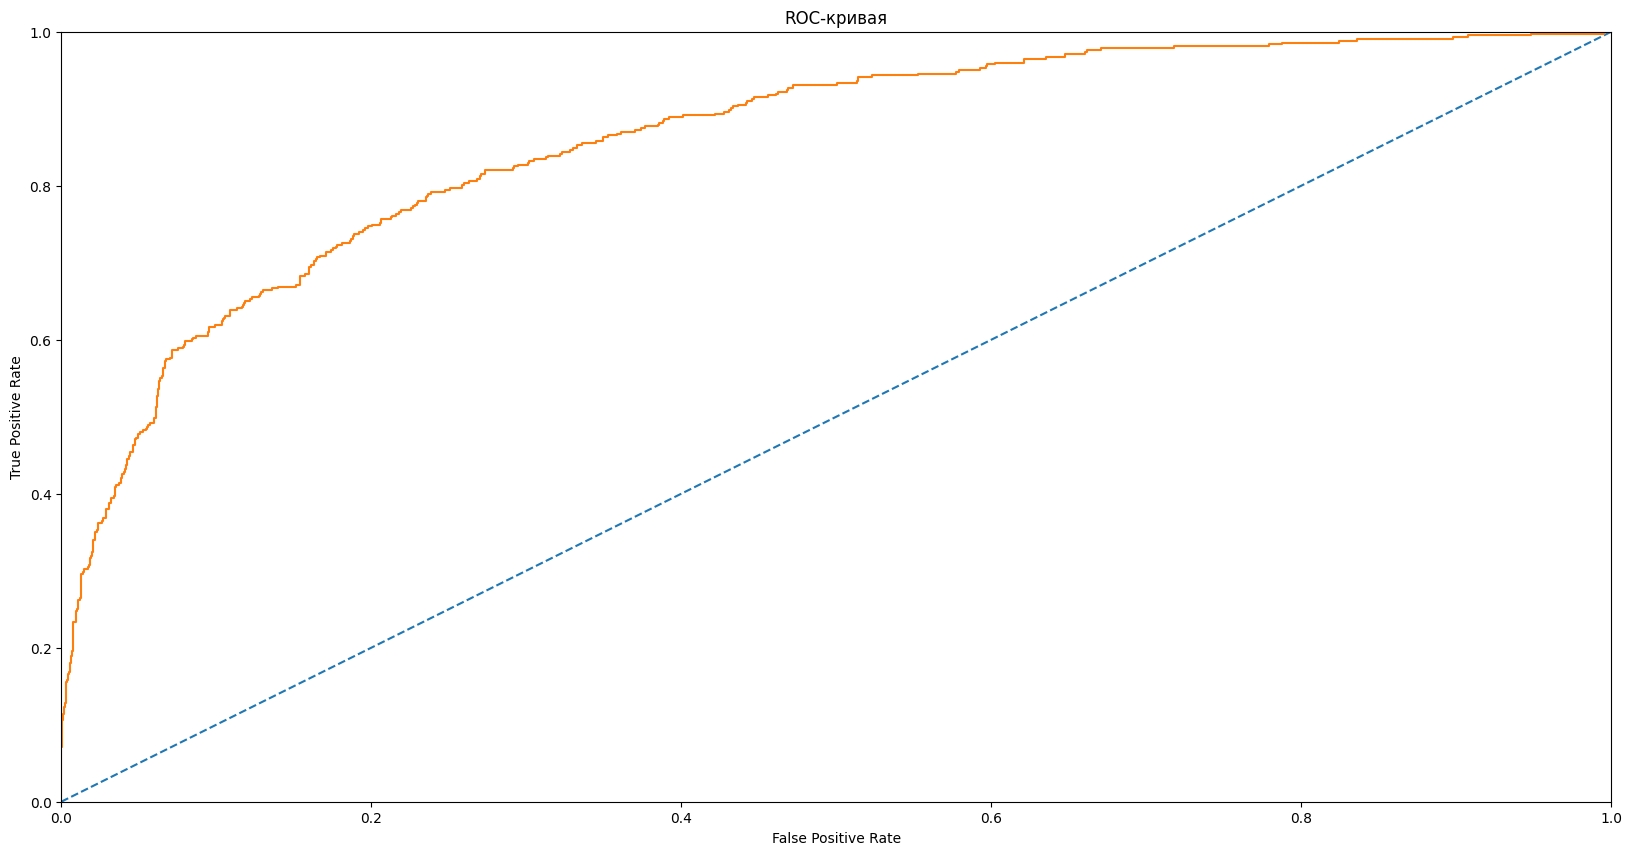

In [96]:
fpr, tpr, threshold = roc_curve(test_target, probability_value_positive)

plt.figure(figsize = (20,10))
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Данный график позволяет определить подходящее соотношение TPR и FPR, а также определить необходимый порог классификации, так как чем ниже порог - тем выше как доля правильных, так и доля ложных срабатываний модели.

# Общий вывод<a id="6"></a>

В процессе исследования оттока клиентов банка определили следующие проблемы:

* имеются пропуски по признаку `Tenure`. Необходимо разобраться в причине появления пропуска и выбрать способ устранения этих пропусков.
* для реализации модели предсказания оттока клиентов имеются лишние данные, которые усложнят процесс обучения модели:  `RowNumber`, `CustomerId`, `Surname`. От этих признаков нужно избавиться.
* в таблице имеются категориальные переменные строкового типа `Geography`, `Gender`. Для обучения модели необходимо провести процедуру прямого кодирования (**OHE**).
* в таблице с количественными признаками используется разный масштаб значений. Необходимо провести стандартизацию признаков.

После подготовки данных выбрали два алгоритма обучения:

* Логистическая регрессия;
* Случайный лес;

Для алгоритма случайного леса подобрали оптимальные гиперпараметры, после чего сделали обучение модели и проверили качество модели с помощью метрики accuracy.

На основе полученных результатов определили, что метрика accuracy - малоинформативна и неэффективна в оценке производительности модели, так как имеется дисбаланс классов по целевому признаку.

Построили матрицу ошибку для модели линейной регрессии и случайного леса и определили F1-меру для каждого из них. Полученные результаты не удовлетворяют ТЗ, а по результатам матрицы ошибок увидели, что модели предсказывают положительный класс плохо. 

Поэтому решили бороться с дисбалансом классов следующими методами: 

* Взвешивание классов;
* Увеличение выборки;
* Уменьшение выборки;
* Изменение порога классификации

Установили: 

* Логистическая регрессия ведет себя хуже, F1-мера при использовании разных методов давала не больше 0.5;
* Случайный лес при заранее определенных гиперпараметрах в каждом методе показала себя лучше. При этом ее результаты удовлетворяют требования ТЗ: F1-мера больше или равная 0.59
* Метод взвешенных классов - наиболее простой способ устранения дисбаланса классов, однака полученный результат F1-меры не самый лучший среди всех остальных остальных способов - "золотая середина";
* Метод увеличения выборки: прост в реализации, хорошие результаты, однако нужно определять оптимальную величину объектов положительного класса, так как можем столкнуться с дисбалансом в сторону положительного класса;
* Аналогично метод уменьшения выборки: хорошие результаты, но необходимо учитывать долю исходных данных, с которой будем обучать нашу модель. Чем больше доля - тем ближе мы приближаемся к исходным результатам и наоборот - чем меньше доля, тем велика вероятность того, что получим дисбаланс классов.
* Метод изменения порога: самые лучшие результаты, метод позволяет изменять границу получения положительного класса моделью, однако необходимо определить: что для нас важнее: полнота или точность?
Чем больше порог - тем выше точность, но меньше полнота и наоборот. Необходимо подобрать оптимальное значение порога, чтобы достичь макимизации полносты и точности.
* Лучшая модель: модель **Случайного леса**
* Метод взвешивания классов:
  * Точность: 0.62
* Метод увеличения выборки:
  * Точность: 0.628
  * Увеличение количества объектов: в 3 раза
* Метод уменшения выборки:
  * Точность: 0.629
  * Уменьшение количества объектов: в 4 раза
* Метод изменения порога классификации:
  * Точность: 0.64
  * Порог классификации: 0.3 

После того, как определили наиболе подходящую модель для финальной проверки на тестовой выборки: 

* Алгоритм **случайного леса**, гиперпараметры определили с помощью `GridSearchCV`;
* Для решения проблемы дисбаланса классов воспользуемся методом **Изменения порога классификации**
* Порог классификации: 0.3

Провели финальное тестирование.

Полученные результаты удовлетворяют условиям заказчикам и при этом получили хорошую точность прогноза положительного класса. 
Проверили с помощью метрик F1-score и AUC-ROC-score.

*    F1-мера: 0.62
*    Площадь кривой ошибок: 0.85

Регулирование порога классификации позволяет получить наиболее лучшие результаты классификации, но необходимо определять наиболее оптимальное значение порога, чтобы достичь макисмума TPR и минимума FPR. 